<a href="https://colab.research.google.com/github/arcweld/DSI_Capstone_3/blob/main/notebooks/7_smw_composite_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geojson
!pip install geemap
!pip install geopandas
!pip install rasterio

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import geojson
import requests

import rasterio as rio
from rasterio.plot import show
import rasterio.mask
import geopandas as gpd
import numpy as np

from rasterio import windows
from shapely.geometry import box
import pandas as pd

import ee
import geemap
import geemap.eefolium as emap

from ipyleaflet import GeoJSON
import os

In [3]:
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=XjXeQlg8IucJTvrwioAJG5buvA0ETZpdGGqBflUz2FM&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWiDK_DybwzB1mdULlR_5DXcbEZqcG7EBablPCnNDZIKEBOTDC8nMNo

Successfully saved authorization token.


In [4]:
from google.colab import drive
drive.mount('/data', force_remount=True)

Mounted at /data


In [5]:
!ls ../data/MyDrive/Galvanize/DSI_Capstone_3/

data		      flask    notebooks   reports
drive		      LICENSE  outputs	   requirements.txt
EE_experiments.ipynb  logs     README.md   src
file_plan.txt	      models   references  testing


In [6]:
us_Counties = '/data/MyDrive/Galvanize/DSI_Capstone_3/data/processed/cb_2018_us_county_20m.json'

In [7]:
us_counties =gpd.read_file(us_Counties)

In [8]:
us_counties.head(5)

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,37,017,01026336,0500000US37017,37017,Bladen,06,2265887723,33010866,"POLYGON ((-78.90200 34.83527, -78.79960 34.850..."
1,37,167,01025844,0500000US37167,37167,Stanly,06,1023370459,25242751,"POLYGON ((-80.49738 35.20210, -80.29542 35.502..."
2,39,153,01074088,0500000US39153,39153,Summit,06,1069181981,18958267,"POLYGON ((-81.68699 41.13596, -81.68495 41.277..."
3,42,113,01213687,0500000US42113,42113,Sullivan,06,1165338428,6617028,"POLYGON ((-76.81373 41.59003, -76.22014 41.541..."
4,48,459,01384015,0500000US48459,48459,Upshur,06,1509910100,24878888,"POLYGON ((-95.15274 32.66095, -95.15211 32.902..."


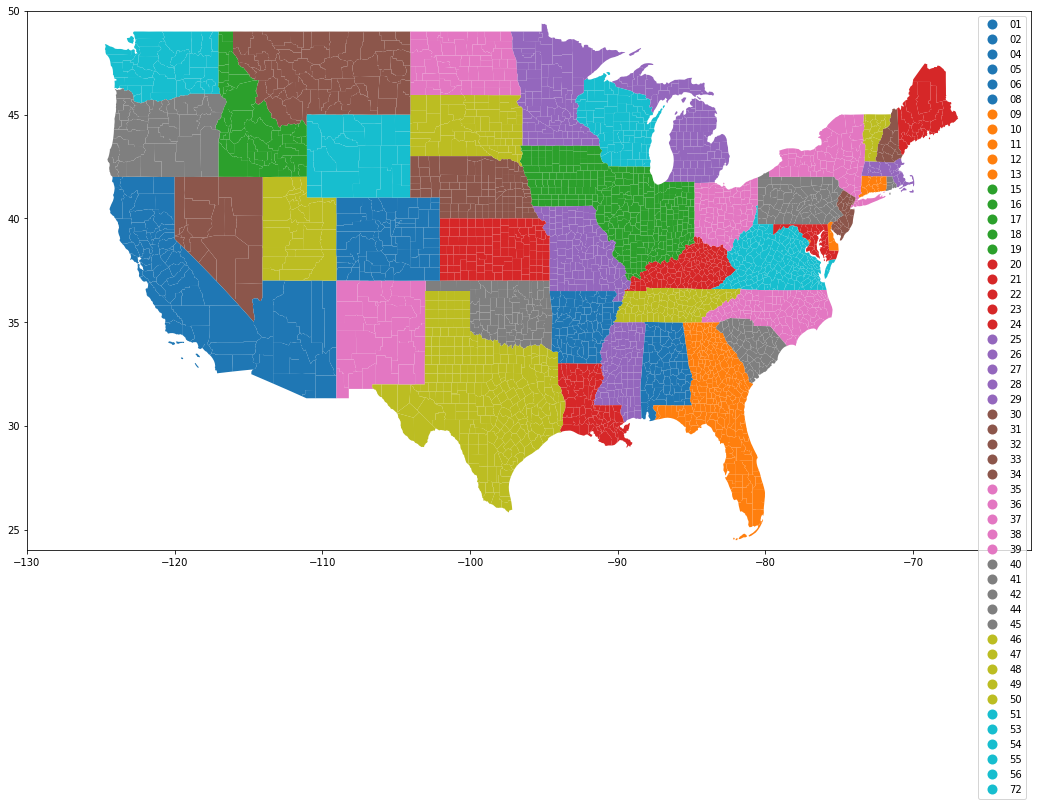

In [10]:
#Visualize
fig, ax=plt.subplots(1,figsize=(18,18))
us_counties.plot('STATEFP',legend=True,ax=ax)
ax.set_xlim(-130,-62)
ax.set_ylim(24,50)
plt.show()


In [12]:
def translate_state(state: str) -> int:
    states = {
    'AL': ('01', 'Alabama'),
    'AK': ('02', 'Alaska'),
    'AZ': ('04', 'Arizona'),
    'AR': ('05', 'Arkansas'),
    'CA': ('06', 'California'),
    'CO': ('08', 'Colorado'),
    'CT': ('09', 'Connecticut'),
    'DE': ('10', 'Delaware'),
    'FL': ('12', 'Florida'),
    'GA': ('13', 'Georgia'),
    'HI': ('15', 'Hawaii'),
    'ID': ('16', 'Idaho'),
    'IL': ('17', 'Illinois'),
    'IN': ('18', 'Indiana'),
    'IA': ('19', 'Iowa'),
    'KS': ('20', 'Kansas'),
    'KY': ('21', 'Kentucky'),
    'LA': ('22', 'Louisiana'),
    'ME': ('23', 'Maine'),
    'MD': ('24', 'Maryland'),
    'MA': ('25', 'Massachusetts'),
    'MI': ('26', 'Michigan'),
    'MN': ('27', 'Minnesota'),
    'MS': ('28', 'Mississippi'),
    'MO': ('29', 'Missouri'),
    'MT': ('30', 'Montana'),
    'NE': ('31', 'Nebraska'),
    'NV': ('32', 'Nevada'),
    'NH': ('33', 'New Hampshire'),
    'NJ': ('34', 'New Jersey'),
    'NM': ('35', 'New Mexico'),
    'NY': ('36', 'New York'),
    'NC': ('37', 'North Carolina'),
    'ND': ('38', 'North Dakota'),
    'OH': ('39', 'Ohio'),
    'OK': ('40', 'Oklahoma'),
    'OR': ('41', 'Oregon'),
    'PA': ('42', 'Pennsylvania'),
    'RI': ('44', 'Rhode Island'),
    'SC': ('45', 'South Carolina'),
    'SD': ('46', 'South Dakota'),
    'TN': ('47', 'Tennessee'),
    'TX': ('48', 'Texas'),
    'UT': ('49', 'Utah'),
    'VT': ('50', 'Vermont'),
    'VA': ('51', 'Virginia'),
    'WA': ('53', 'Washington'),
    'WV': ('54', 'West Virginia'),
    'WI': ('55', 'Wisconsin'),
    'WY': ('56', 'Wyoming'),
    'DC': ('11', 'Washington, DC'),
    'PR': ('72', 'Puerto Rico')
    }
    return states[state.upper()]

In [16]:
state_name = 'ks'
state = us_counties[us_counties.STATEFP == translate_state(state_name)[0]]

In [14]:
state_num = '72'
state = us_counties[us_counties.STATEFP == state_num]

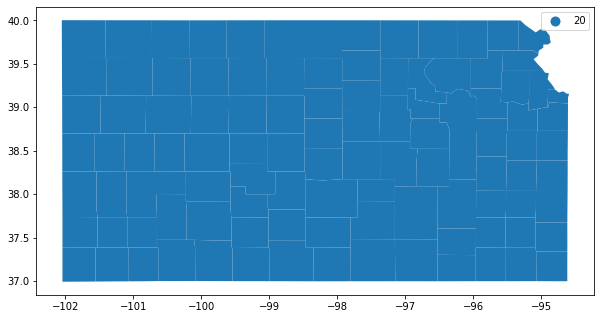

In [17]:
fig, ax=plt.subplots(1,figsize=(10,10))
state.plot('STATEFP',legend=True,ax=ax)
plt.show()


In [18]:
# Get the polygon for a county's admin district
county_name = 'butler'.capitalize()
county = state[state.NAME == county_name]

In [19]:
county.NAME

2708    Butler
Name: NAME, dtype: object

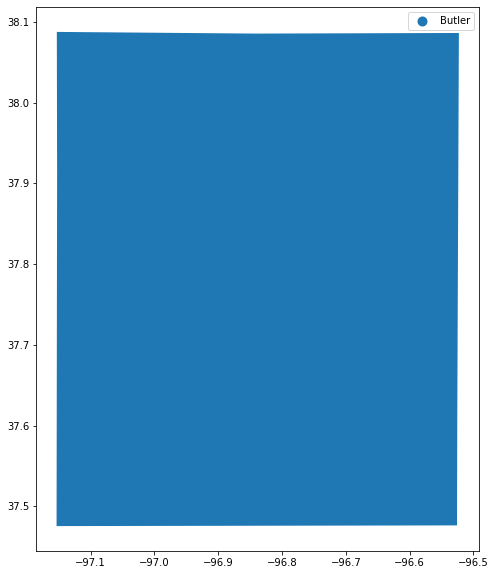

In [20]:
fig, ax=plt.subplots(1,figsize=(10,10))
county.plot('NAME',legend=True,ax=ax)
plt.show()

In [21]:
# Generate centroid and polygon
centroid = county.centroid.iloc[0].coords[0]
minx=county.bounds['minx'].values[0]
miny=county.bounds['miny'].values[0]
maxx=county.bounds['maxx'].values[0]
maxy=county.bounds['maxy'].values[0]
geometry = ee.Geometry.Rectangle([minx,miny,maxx,maxy])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [ ]:
def generate_naip_image(
    region, 
    centroid, 
    product='USDA/NAIP/DOQQ', 
    min_date='2019-01-01',
    max_date='2021-12-31',
    debug=True
):

    """Generates NAIP image using Google Earth Engine."""
             
    image = ee.ImageCollection(product)\
        .filterBounds(region)\
        .filterDate(str(min_date), str(max_date))\
        .mosaic()

    image = image.select('R','G','B','N')
      
    return image.clip(region) #return Image

In [146]:
def read_counties(file='../data/processed/cb_2018_us_county_20m.json'):
    """Reads in data from a geojson file.
    Parameter:
        file (str) -- path and name of geojson file
    Returns:
        geopandas DataFrame with GeoJSON data on all counties
    """
    # logging.debug(f'running `read_counties` function\n')
    return gpd.read_file(file)

def conus_map(counties):
    """Plot map of all states in CONUS with county outlines
    """
    # logging.debug(f'running `conus_map` function\n')
    fig, ax = plt.subplots(1,figsize=(10,10))
    counties.plot('STATEFP',legend=False,ax=ax)
    ax.set_xlim(-130,-62)
    ax.set_ylim(24,50)
    plt.savefig("../outputs/conus.png")
    plt.show(block=False)
    return fig


def select_county(counties, state_name, county_name):
    """Selects county geojson data from geopandas DataFrame
    Parameters:
        counties (geopandas DataFrame) -- US counties
        state (str or int) -- state of interest
        county (str) -- county of interest
    Returns:
        geopandas Series with county geojson data
    """
    # logging.debug(f'running `select_county` function\n')
    if state_name.isdigit():
        state = counties[counties.STATEFP == state_name]
    else:
        state = counties[counties.STATEFP == translate_state(state_name)[0]]
    return state[state.NAME == county_name.capitalize()]


def centroid_and_polygon(county):
    """Generate centroid and polygon for selected county.
    """
    # logging.debug(f'running `centroid_and_polygon` function\n')
    minx=county.bounds['minx'].values[0]
    miny=county.bounds['miny'].values[0]
    maxx=county.bounds['maxx'].values[0]
    maxy=county.bounds['maxy'].values[0]

    geometry = ee.Geometry.Rectangle([minx,miny,maxx,maxy])
    centroid = county.centroid.iloc[0].coords[0]

    return geometry, centroid


def product_parameters(product):
    """Define band and signal parameters for different imagery
    """
    if product.upper()[0:7] == 'LANDSAT':
        product =  'LANDSAT/LC08/C01/T1'
        band_d = {'R': 'B4', 'G': 'B3', 'B': 'B2', 'NIR': 'B5', 'SWIR1': 'B6', 'SWIR2': 'B7'}
        range_min=0.
        range_max=3000.
    else:
        product = 'USDA/NAIP/DOQQ'
        band_d = {'R': 'R', 'G': 'G', 'B': 'B', 'NIR': 'N'}
        range_min=0.
        range_max=255.

    return product, band_d, range_min, range_max


def generate_image(
    region,
    centroid,
    bands='RGB',
    product='NAIP',
    min_date='2019-01-01',
    max_date='2021-12-31',
    debug=True
    ):
    """Generates image using Google Earth Engine.
    Parameters:
        region (geopandas Series)
        centroid  (geopandas Series)
        product (str) - either 'NAIP' (default) or 'LANDSAT'
        min_date (str)
        max_date (str)
        bands (str) - spectral bands for image selection
    """
    product, band_d, range_min, range_max = product_parameters(product)

    image = ee.ImageCollection(product)\
        .filterBounds(region)\
        .filterDate(str(min_date), str(max_date))\
        .mosaic()

    if bands == 'RGB':
        image = image.select([band_d['R'], band_d['G'], band_d['B']])
    elif bands == 'RGB_NIR':
        image = image.select([band_d['R'], band_d['G'], band_d['B'], band_d['NIR']])
    elif bands == "RGB_NIR_SWIR":
        image = image.select([band_d['R'], band_d['G'], band_d['B'], band_d['NIR'], band_d['SWIR1'], band_d['SWIR2']])
    else:
        image = image.select([band_d['R'], band_d['G'], band_d['B']])

    return image.clip(region)


def create_map(centroid, images):
    """ Create map in area of interest
    """
    Map = emap.Map(tiles='Stamen Toner',
                    add_google_map=False,
                    center=[centroid[1], centroid[0]],
                    zoom=10,
                    zoom_control=False,
                    scrollWheelZoom=False,
                    dragging=False)

    for im in images:
        Map.addLayer(im[0], im[1], im[2])
        
    Map.addLayerControl()

    return Map


def true_colour_composites(image, product):
    # 
    product, band_d, range_min, range_max = product_parameters(product)

    image_rgb = image.visualize(bands=[band_d['R'], band_d['G'], band_d['B']], min=range_min, max=range_max)
    
    return image_rgb


def false_colour_composite(image, product):
    # 
    product, band_d, range_min, range_max = product_parameters(product)

    image_ngb = image.visualize(bands=[band_d['NIR'], band_d['G'], band_d['B']], min=range_min, max=range_max)
    
    return image_ngb

def ndvi_composite(image, product):
    ## Create NDVI (normalized difference Vegetation Index) image map
    product, band_d, range_min, range_max = product_parameters(product)

    nir_ = image.select(band_d['NIR'])
    red_ = image.select(band_d["R"])

    ndvi_ = nir_.subtract(red_).divide(nir_.add(red_)).rename("NDVI")
    visParamsNdvi_ = {min:-1, max:1,"palette":["grey","white","green"]}

    return ndvi_, visParamsNdvi_


In [122]:
product ='NAIP'
image = generate_image(
    geometry, 
    centroid,
    bands='RGB_NIR', 
    product=product, 
    min_date='2019-01-01',
    max_date='2021-12-31'
    )

In [142]:
image_rgb = true_colour_composites(image, product)
image_ngb = false_colour_composite(image, product)
image_ndvi, params_ndvi = ndvi_composite(image, product)

images = [[image_rgb, {}, 'True Color'], 
          [image_ngb, {}, 'False Color'], 
          [image_ndvi, params_ndvi, 'NDVI']]

In [147]:
Map = create_map(centroid, images)

Map